**bold text**# SkimLit

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper we're replicating is available here: https://arxiv.org/abs/1710.06071

Based on the paper above the architecture used to achieve state of the art results is available here: https://arxiv.org/abs/1612.05251

In [ ]:
#confirming gpu availability

!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-e2b0d21d-b3ed-6dff-a3cc-c9a83c572623)


## Downloading dataset

Available from author's Github

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [ ]:
!head pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt

###24293578
OBJECTIVE	To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .
METHODS	A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .
METHODS	Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .
METHODS	Pain was assessed using the visual analog pain scale ( @-@ mm ) .
METHODS	Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .
METHODS	Serum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and high-sensitivity C-reactive protein ( hsCRP 

In [ ]:
# Start experimentation with the 20k '@' sign dataset
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
!head pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt

###24290286
BACKGROUND	IgE sensitization to Aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .
BACKGROUND	It is not clear whether these patients would benefit from antifungal treatment .
OBJECTIVE	We sought to determine whether a @-month course of voriconazole improved asthma-related outcomes in patients with asthma who are IgE sensitized to A fumigatus .
METHODS	Asthmatic patients who were IgE sensitized to A fumigatus with a history of at least @ severe exacerbations in the previous @ months were treated for @ months with @ mg of voriconazole twice daily , followed by observation for @ months , in a double-blind , placebo-controlled , randomized design .
METHODS	Primary outcomes were improvement in quality of life at the end of the treatment period and a reduction in the number of severe exacerbations over the @ months of the study .
RESULTS	Sixty-five patients were randomized .
RESULTS	Fifty-nine patients started treatme

In [ ]:
def get_lines(filename):
  with open(filename, "r") as f:
    text = f.readlines()

  return text

In [ ]:
train_lines = get_lines(data_dir+"train.txt")

In [ ]:
train_lines[:25]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

### Representation of data

```
[{'line_number': 0,
  'target': 'Background',
  'text': 'Emotional eating is associated with overeating and the development of obesity .\n',
  'total_lines': 11},
...]
```

In [ ]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dicts
  """

  input_lines = get_lines(filename)
  abstract_lines = ""
  abstract_samples = []

  for line in input_lines:
    if line.startswith('###'):
      abstract_id = line
      abstract_lines = ""
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()
      for abstract_line_number, abstract_line in  enumerate(abstract_line_split):
        abstract_target, abstract_text = abstract_line.split('\t')
        abstract_samples.append({
            'target': abstract_target,
            'text': abstract_text,
            'line_number': abstract_line_number,
            'total_lines': len(abstract_line_split)-1
        })
    else:
      abstract_lines += line

  return abstract_samples

In [ ]:
%%time
train_samples = preprocess_text_with_line_numbers(data_dir+"train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir+"dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir+"test.txt")

CPU times: user 582 ms, sys: 130 ms, total: 712 ms
Wall time: 1.06 s


In [ ]:
train_samples[:12]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'Secondary outcome measures include

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [ ]:
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,A total of @ patients with primary knee OA wer...,1,11
2,METHODS,Outcome measures included pain reduction and i...,2,11
3,METHODS,Pain was assessed using the visual analog pain...,3,11
4,METHODS,Secondary outcome measures included the Wester...,4,11
5,METHODS,"Serum levels of interleukin @ ( IL-@ ) , IL-@ ...",5,11
6,RESULTS,There was a clinically relevant reduction in t...,6,11
7,RESULTS,The mean difference between treatment arms ( @...,7,11
8,RESULTS,"Further , there was a clinically relevant redu...",8,11
9,RESULTS,These differences remained significant at @ we...,9,11


In [ ]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

In [ ]:
train_sentences = train_df.text.tolist()
val_sentences = val_df.text.tolist()
test_sentences = test_df.text.tolist()

## Make Numeric labels

In [ ]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))

train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
import tensorflow as tf

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

In [ ]:
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
class_names = one_hot_encoder.categories_[0]

In [ ]:
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [ ]:
class_names[0]

'BACKGROUND'

## Model 0: Getting a baseline

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [ ]:
baseline_preds = model_0.predict(val_sentences)

## Preparing Data for Deep Sequence Models

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

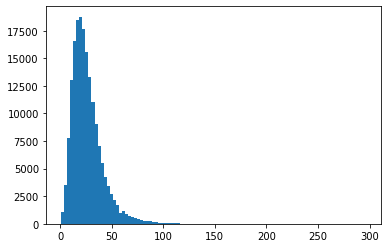

In [ ]:
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=100);

In [ ]:
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [ ]:
text_vectorizer = layers.TextVectorization(max_tokens=68000,
                                           standardize="lower_and_strip_punctuation",
                                           split="whitespace",
                                           ngrams=None,
                                           output_mode='int',
                                           output_sequence_length=output_seq_len)

text_vectorizer.adapt(train_sentences)

In [ ]:
import random
target_sentence = random.choice(train_sentences)
print(target_sentence)
print(f"\n{len(target_sentence.split())}")
print(f"\n{text_vectorizer([target_sentence])}")

We aimed to develop prognostic nomograms to predict overall survival ( OS ) and progression-free survival ( PFS ) for patients treated with imatinib .

25

[[   43   447     6  1377  1151 14686     6  1359   188   201   653     3
   1090   201   865    11    12   172     7  5835     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [ ]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
len(rct_20k_text_vocab),rct_20k_text_vocab[:5],rct_20k_text_vocab[-5:]

(64841,
 ['', '[UNK]', 'the', 'and', 'of'],
 ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp'])

In [ ]:
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                               output_dim=512,
                               input_length=output_seq_len,
                               mask_zero=True,
                               name="token_embedding")

In [ ]:
token_embed(text_vectorizer([target_sentence]))

<tf.Tensor: shape=(1, 55, 512), dtype=float32, numpy=
array([[[-0.01037312, -0.00781401,  0.0205842 , ..., -0.02021924,
          0.00385066, -0.03025258],
        [ 0.03700188,  0.00331687, -0.01769652, ..., -0.035146  ,
         -0.01830201, -0.01219057],
        [ 0.02832042, -0.00977614,  0.00735677, ...,  0.03627107,
         -0.00031818, -0.03826215],
        ...,
        [-0.01769197, -0.00228018, -0.03904145, ..., -0.02650042,
          0.00497438,  0.02861961],
        [-0.01769197, -0.00228018, -0.03904145, ..., -0.02650042,
          0.00497438,  0.02861961],
        [-0.01769197, -0.00228018, -0.03904145, ..., -0.02650042,
          0.00497438,  0.02861961]]], dtype=float32)>

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

In [ ]:
train_dataset_batched = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset_batched = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset_batched = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

## Model 1: Conv1D with token embeddings

In [ ]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(len(class_names), activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
history_1 = model_1.fit(train_dataset_batched,
                        steps_per_epoch=int(len(train_dataset_batched)),
                        epochs=3,
                        validation_data=val_dataset_batched,
                        validation_steps=len(val_dataset_batched))

Epoch 1/3
5627/5627 [==============================] - 124s 22ms/step - loss: 0.2694 - accuracy: 0.9109 - val_loss: 0.7748 - val_accuracy: 0.7820
Epoch 2/3
5627/5627 [==============================] - 131s 23ms/step - loss: 0.1661 - accuracy: 0.9472 - val_loss: 0.9760 - val_accuracy: 0.7733
Epoch 3/3
5627/5627 [==============================] - 128s 23ms/step - loss: 0.1211 - accuracy: 0.9641 - val_loss: 1.1559 - val_accuracy: 0.7659


## Model 2: Pretrained Feature Extraction with Token Embeddings

In [ ]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
outputs = layers.Dense(len(class_names), activation="softmax")(x)

model_2 = tf.keras.Model(inputs, outputs)

model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

history_2 = model_2.fit(train_dataset_batched,
                        steps_per_epoch=int(len(train_dataset_batched)),
                        epochs=3,
                        validation_data=val_dataset_batched,
                        validation_steps=len(val_dataset_batched))

Epoch 1/3
5627/5627 [==============================] - 70s 12ms/step - loss: 0.7288 - accuracy: 0.7216 - val_loss: 0.6553 - val_accuracy: 0.7504
Epoch 2/3
5627/5627 [==============================] - 70s 12ms/step - loss: 0.6330 - accuracy: 0.7594 - val_loss: 0.6215 - val_accuracy: 0.7634
Epoch 3/3
5627/5627 [==============================] - 69s 12ms/step - loss: 0.5994 - accuracy: 0.7733 - val_loss: 0.6073 - val_accuracy: 0.7681


## Model 3: Using character tokenization

In [ ]:
def split_chars(text):
  return " ".join(list(text))


In [ ]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [ ]:
train_chars[:5]

['T o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   O A   )   .',
 'A   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   O A   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'O u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [ ]:
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

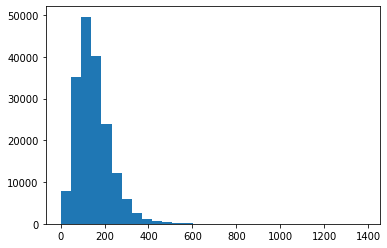

In [ ]:
plt.hist(char_lens, bins=30);

In [ ]:
output_seq_char_len = int(np.percentile(char_lens, 95))

In [ ]:
np.unique(train_chars, axis=-1)

array(['# N C T   @   ,   F e b r u a r y   @   ,   @   .',
       '%   D B V   a n d   A D B V   w e r e   m e a s u r e d   b y   m a g n e t i c   r e s o n a n c e   i m a g i n g   .',
       '%   E B W   a t   t h e   @ - m o n t h   f o l l o w - u p   w a s   s t r o n g l y   c o r r e l a t e d   w i t h   t h e   r e s u m p t i o n   o f   m e n s e s   .',
       ...,
       'w w w . i s r c t n . o r g   i d e n t i f i e r   :   I S R C T N @   .',
       'w w w . t r i a l r e g i s t e r . n l   ,   i d e n t i f i c a t i o n   N T R @   .',
       'z i n c   s u p p l e m e n t s   m a y   b e n e f i t   i n   m a n a g e m e n t   o f   p a t i e n t s   w i t h   c h r o n i c   p r o s t a t i t i s   N I H - I I I A   .'],
      dtype='<U2771')

In [ ]:
big_string = ""
for sentence in train_sentences:
  big_string += sentence.lower()

In [ ]:
all_chars = list(set(list(big_string)))
NUM_CHAR_TOKENS = len(all_chars) + 1

In [ ]:
char_vectorizer = layers.TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                           output_sequence_length=output_seq_char_len,
                                           standardize="lower_and_strip_punctuation",
                                           name="char_vectorizer")

In [ ]:
char_vectorizer.adapt(train_chars)

In [ ]:
char_vocab = char_vectorizer.get_vocabulary()
print(len(char_vocab))
print(char_vocab[:5])
print(char_vocab[-5:])

28
['', '[UNK]', 'e', 't', 'i']
['k', 'x', 'z', 'q', 'j']


In [ ]:
char_embed = layers.Embedding(input_dim=len(char_vocab),
                              output_dim=25,
                              mask_zero=True,
                              input_length=output_seq_char_len)

In [ ]:
train_chars_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot))
val_chars_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot))
test_chars_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot))

In [ ]:
train_dataset_chars_batched = train_chars_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset_chars_batched = val_chars_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset_chars_batched = test_chars_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=7, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(len(class_names), activation="softmax")(x)

model_3 = tf.keras.Model(inputs, outputs)

model_3.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
history_3 = model_3.fit(train_dataset_chars_batched,
                        steps_per_epoch=int(len(train_dataset_chars_batched)),
                        epochs=3,
                        validation_data=val_dataset_chars_batched,
                        validation_steps=len(val_dataset_chars_batched))

Epoch 1/3
5627/5627 [==============================] - 32s 6ms/step - loss: 0.8724 - accuracy: 0.6614 - val_loss: 0.7722 - val_accuracy: 0.7035
Epoch 2/3
5627/5627 [==============================] - 30s 5ms/step - loss: 0.7301 - accuracy: 0.7236 - val_loss: 0.7183 - val_accuracy: 0.7274
Epoch 3/3
5627/5627 [==============================] - 30s 5ms/step - loss: 0.6907 - accuracy: 0.7395 - val_loss: 0.7002 - val_accuracy: 0.7359


In [ ]:
model_3.evaluate(test_dataset_chars_batched)

942/942 [==============================] - 3s 4ms/step - loss: 0.7187 - accuracy: 0.7284


[0.7187485098838806, 0.7283557057380676]

## Model 4

1. Create a token-level embedding model
2. Create a character-level model
3. Combine 1 and 2 with a concatenate layer
4. Build a series of layers on top of 3
5. Construct a model which takes token level and character-level sequences as input and produces sequence label probabilities as output

In [ ]:
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs, outputs=token_output)

char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs, outputs=char_bi_lstm)

token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, char_model.output])

combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(len(class_names), activation="softmax")(final_dropout)

model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer)

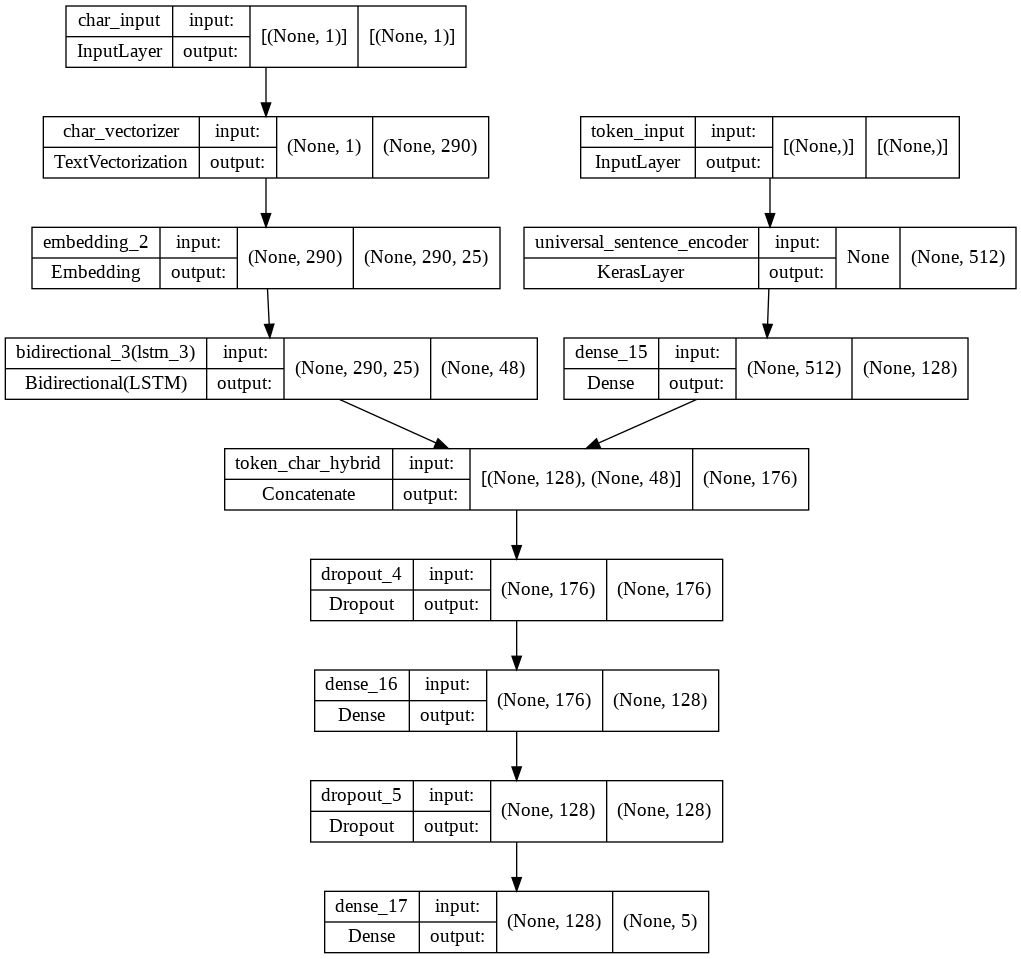

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [ ]:
model_4.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))

val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))

test_char_token_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars))
test_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_dataset = tf.data.Dataset.zip((test_char_token_data, test_char_token_labels))



train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_char_token_dataset = test_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
history_4 = model_4.fit(train_char_token_dataset,
                        steps_per_epoch=int(len(train_char_token_dataset)),
                        epochs=3,
                        validation_data=val_char_token_dataset,
                        validation_steps=len(val_char_token_dataset))

Epoch 1/3
5627/5627 [==============================] - 275s 47ms/step - loss: 0.7595 - accuracy: 0.7106 - val_loss: 0.6205 - val_accuracy: 0.7629
Epoch 2/3
5627/5627 [==============================] - 262s 47ms/step - loss: 0.6694 - accuracy: 0.7487 - val_loss: 0.5858 - val_accuracy: 0.7772
Epoch 3/3
5627/5627 [==============================] - 262s 46ms/step - loss: 0.6445 - accuracy: 0.7579 - val_loss: 0.5749 - val_accuracy: 0.7821


## Create positional embeddings

In [ ]:
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)
alternate_train_line_numbers = tf.constant(train_df["line_number"]/train_df['total_lines'])
alternate_val_line_numbers = tf.constant(val_df["line_number"]/val_df['total_lines'])
alternate_test_line_numbers = tf.constant(test_df["line_number"]/test_df['total_lines'])


In [ ]:
alternate_val_line_numbers[:50]
train_line_numbers_one_hot[0]

<tf.Tensor: shape=(15,), dtype=float32, numpy=
array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)>

In [ ]:
np.percentile(train_df.total_lines, 98)

20.0

In [ ]:
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

## Model 5

In [ ]:
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs, outputs=token_outputs)

char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

line_num_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_num_inputs")
line_num_outputs = layers.Dense(8, activation="relu")(line_num_inputs)
line_num_model = tf.keras.Model(inputs=line_num_inputs, outputs=line_num_outputs)

total_line_num_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_line_num_inputs")
total_line_num_outputs = layers.Dense(16, activation="relu")(total_line_num_inputs)
total_line_num_model = tf.keras.Model(inputs=total_line_num_inputs, outputs=total_line_num_outputs)


combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output, char_model.output])

z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

tribrid_embeddings = layers.Concatenate(name="positional_embedding")([line_num_model.output, total_line_num_model.output, z])
combined_dense = layers.Dense(256, activation="relu")(tribrid_embeddings)

final_dropout = layers.Dropout(0.5)(combined_dense)

output_layer = layers.Dense(len(class_names), activation="softmax")(final_dropout)

model_5 = tf.keras.Model(inputs=[token_model.input,
                                 char_model.input,
                                 line_num_model.input,
                                 total_line_num_model.input],
                         outputs=output_layer)

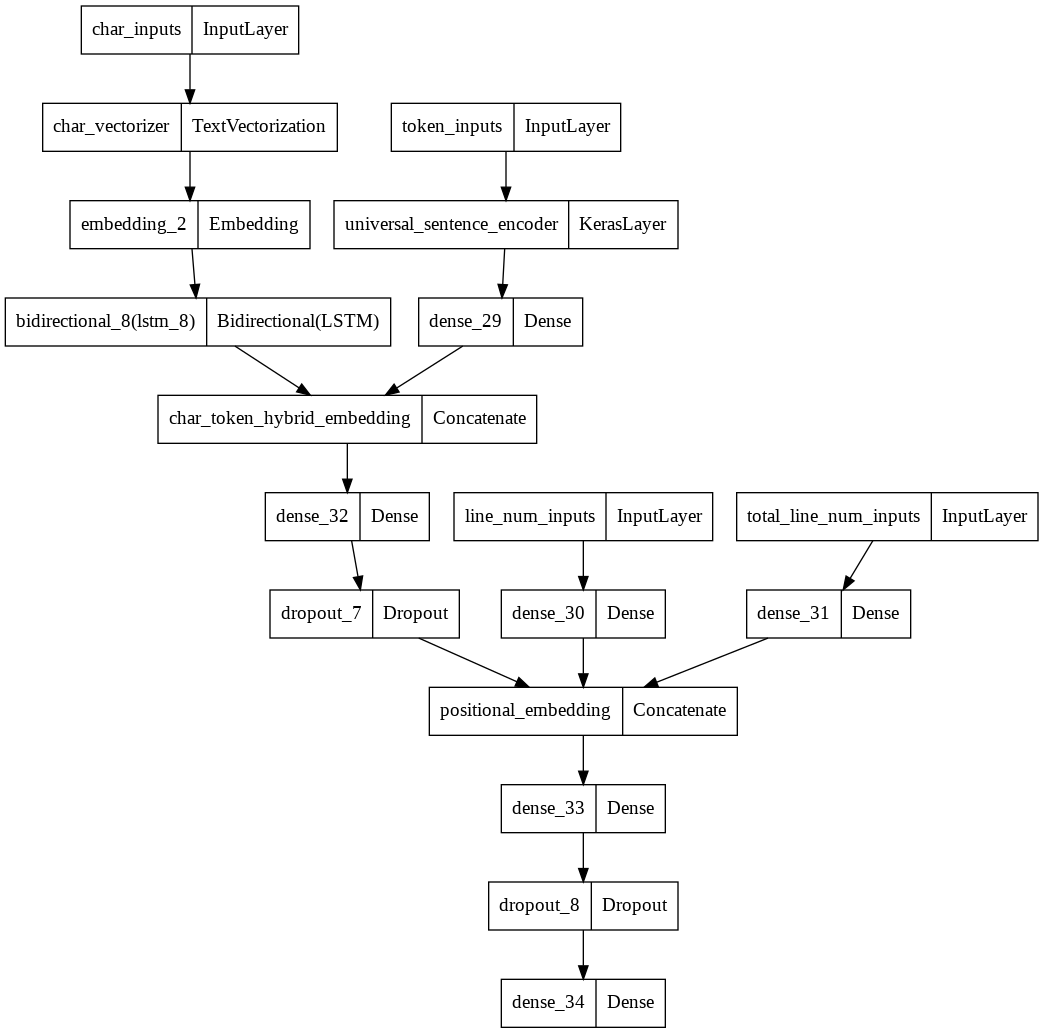

In [ ]:
plot_model(model_5)

In [ ]:
model_5.summary()

Model: "model_35"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']    

In [ ]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_sentences,
                                                                train_chars,
                                                                train_line_numbers_one_hot,
                                                                train_total_lines_one_hot))
train_char_token_pos_labels =  tf.data.Dataset.from_tensor_slices((train_labels_one_hot))
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))

val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_sentences,
                                                                val_chars,
                                                                val_line_numbers_one_hot,
                                                                val_total_lines_one_hot))
val_char_token_pos_labels =  tf.data.Dataset.from_tensor_slices((val_labels_one_hot))
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))

test_char_token_pos_data = tf.data.Dataset.from_tensor_slices((test_sentences,
                                                                test_chars,
                                                                test_line_numbers_one_hot,
                                                                test_total_lines_one_hot))
test_char_token_pos_labels =  tf.data.Dataset.from_tensor_slices((test_labels_one_hot))
test_char_token_pos_dataset = tf.data.Dataset.zip((test_char_token_pos_data, test_char_token_pos_labels))



train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_char_token_pos_dataset = test_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
history_5 = model_5.fit(train_char_token_pos_dataset,
                        steps_per_epoch=int(len(train_char_token_pos_dataset)),
                        epochs=3,
                        validation_data=val_char_token_pos_dataset,
                        validation_steps=len(val_char_token_pos_dataset))

Epoch 1/3
5627/5627 [==============================] - 312s 54ms/step - loss: 0.9362 - accuracy: 0.8300 - val_loss: 0.8675 - val_accuracy: 0.8644
Epoch 2/3
5627/5627 [==============================] - 266s 47ms/step - loss: 0.8838 - accuracy: 0.8655 - val_loss: 0.8601 - val_accuracy: 0.8703
Epoch 3/3
5627/5627 [==============================] - 265s 47ms/step - loss: 0.8706 - accuracy: 0.8745 - val_loss: 0.8567 - val_accuracy: 0.8721


## Model 6 Fully Improved

Redo but with slight changes:

1. Use ratio for line number instead of onehot encoding
2. Improve token model(attempt CNN feature extraction model)
3. Improve Char model(Use full Bidirectional model
4. Decrease Batch size
5. Shuffle data


### Setting up data and imports

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!unzip pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip -d pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
Checking out files: 100% (13/13), done.
Archive:  pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip
  inflating: pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.txt  


In [ ]:
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
from tensorflow.keras import layers
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [ ]:
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
def get_lines(filename):
  with open(filename, "r") as f:
    text = f.readlines()

  return text

In [ ]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dicts
  """

  input_lines = get_lines(filename)
  abstract_lines = ""
  abstract_samples = []

  for line in input_lines:
    if line.startswith('###'):
      abstract_id = line
      abstract_lines = ""
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()
      for abstract_line_number, abstract_line in  enumerate(abstract_line_split):
        abstract_target, abstract_text = abstract_line.split('\t')
        abstract_samples.append({
            'target': abstract_target,
            'text': abstract_text,
            'line_number': abstract_line_number,
            'total_lines': len(abstract_line_split)-1
        })
    else:
      abstract_lines += line

  return abstract_samples

In [ ]:
def get_model_metrics(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [ ]:
train_samples = preprocess_text_with_line_numbers(data_dir+"train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir+"dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir+"test.txt")

In [ ]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [ ]:
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))

class_names = one_hot_encoder.categories_[0]

In [ ]:
train_line_numbers = tf.constant(train_df["line_number"]/train_df['total_lines'])
val_line_numbers = tf.constant(val_df["line_number"]/val_df['total_lines'])
test_line_numbers = tf.constant(test_df["line_number"]/test_df['total_lines'])

In [ ]:
def split_chars(text):
  return " ".join(list(text))

In [ ]:
char_lens = [len(sentence) for sentence in train_df.text.to_list()]
train_chars = [split_chars(sentence) for sentence in train_df.text.to_list()]
val_chars = [split_chars(sentence) for sentence in val_df.text.to_list()]
test_chars = [split_chars(sentence) for sentence in test_df.text.to_list()]



In [ ]:
sent_lens = [len(sentence.split()) for sentence in train_df.text.to_list()]
output_seq_len = int(np.percentile(sent_lens, 99))

In [ ]:
output_seq_char_len = int(np.percentile(char_lens, 99))

In [ ]:
NUM_CHAR_TOKENS=60

### Setting up embeddings and vectors

In [ ]:
train_chars_batch = tf.data.Dataset.from_tensor_slices((train_chars)).batch(128)

In [ ]:
char_vectorizer = layers.TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                           output_sequence_length=output_seq_char_len,
                                           standardize=None,
                                           name="char_vectorizer",
                                           ngrams=3)

char_vectorizer.adapt(train_chars_batch)

In [ ]:
char_vocab = char_vectorizer.get_vocabulary()

char_embed = layers.Embedding(input_dim=len(char_vocab),
                              output_dim=25,
                              mask_zero=True,
                              input_length=output_seq_char_len)

In [ ]:

token_embed = layers.Embedding(input_dim=247961,
                               output_dim=512,
                               input_length=output_seq_len,
                               mask_zero=True,
                               name="token_embedding")

tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")


### Setting up datasets

In [ ]:
train_data = tf.data.Dataset.from_tensor_slices(((train_df.text.to_list(),
                                                  train_chars,
                                                  train_line_numbers), 
                                                 train_labels_one_hot)).shuffle(len(train_df)).batch(16).prefetch(tf.data.AUTOTUNE)

val_data = tf.data.Dataset.from_tensor_slices(((val_df.text.to_list(),
                                                  val_chars,
                                                  val_line_numbers), 
                                                 val_labels_one_hot)).batch(16).prefetch(tf.data.AUTOTUNE)

test_data = tf.data.Dataset.from_tensor_slices(((test_df.text.to_list(),
                                                  test_chars,
                                                  test_line_numbers), 
                                                 test_labels_one_hot)).batch(16).prefetch(tf.data.AUTOTUNE)

### Setting up model

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/tensorflow/weights_only.tf')
model.trainable = True

for layer in model.layers:
  layer.trainable = False
model.layers[3].trainable = True
# model.layers[7].trainable = True
# model.layers[9].trainable = True
# model.layers[15].trainable = True
# model.layers[19].trainable = True
# model.layers[21].trainable = True

for layer_number, layer in enumerate(model.layers):
  print(layer_number, layer.name, layer.trainable)

0 char_inputs False
1 token_inputs False
2 char_vectorizer False
3 universal_sentence_encoder True
4 embedding False
5 reshape False
6 bidirectional False
7 conv1d False
8 bidirectional_1 False
9 global_max_pooling1d False
10 bidirectional_2 False
11 dropout False
12 dropout_1 False
13 char_token_hybrid_embedding False
14 line_num_inputs False
15 dense_1 False
16 dense False
17 dropout_2 False
18 positional_embedding False
19 dense_2 False
20 dropout_3 False
21 dense_3 False


In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
              optimizer=tf.keras.optimizers.Adam(learning_rate=10e-5),
              metrics=['accuracy'])

history = model.fit(train_data,
                    steps_per_epoch=int(len(train_data)),
                    epochs=100,
                    validation_data=val_data,
                    validation_steps=int(len(val_data)),
                    # initial_epoch = history.epoch[-1],
                    callbacks=[early_stopping_callback,])

Epoch 1/100
11253/11253 [==============================] - 2370s 208ms/step - loss: 0.8354 - accuracy: 0.8995 - val_loss: 0.8266 - val_accuracy: 0.8923
Epoch 2/100
11253/11253 [==============================] - 2337s 208ms/step - loss: 0.8250 - accuracy: 0.9073 - val_loss: 0.8212 - val_accuracy: 0.8963
Epoch 3/100
11253/11253 [==============================] - 2350s 209ms/step - loss: 0.8155 - accuracy: 0.9144 - val_loss: 0.8194 - val_accuracy: 0.8973
Epoch 4/100
11033/11253 [============================>.] - ETA: 43s - loss: 0.8077 - accuracy: 0.9202

In [ ]:
model.save('/content/drive/MyDrive/tensorflow/final_model.tf')

In [ ]:
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
reshaped_tokens = layers.Reshape((1,512))(token_embeddings)
convolved_tokens = layers.Conv1D(64, kernel_size=3, padding="same", activation="relu")(reshaped_tokens)
pooled_tokens = layers.GlobalMaxPooling1D()(convolved_tokens)
token_dropout = layers.Dropout(0.5)(pooled_tokens)
token_outputs = layers.Dense(256, activation="relu")(token_dropout)
token_model = tf.keras.Model(inputs=token_inputs, outputs=token_outputs)

char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm_0 = layers.Bidirectional(layers.LSTM(64, return_sequences=True, name="LSTM_1_and_2"))(char_embeddings)
char_bi_lstm_1 = layers.Bidirectional(layers.LSTM(64, return_sequences=True, name="LSTM_3_and_4"))(char_bi_lstm_0)
char_bi_lstm_output = layers.Bidirectional(layers.LSTM(64))(char_bi_lstm_1)
char_dropout = layers.Dropout(0.5)(char_bi_lstm_output)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_dropout)

line_num_inputs = layers.Input(shape=(1,), dtype=tf.float32, name="line_num_inputs")
line_num_outputs = layers.Dense(8, activation="relu")(line_num_inputs)
line_num_model = tf.keras.Model(inputs=line_num_inputs, outputs=line_num_outputs)


combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output, char_model.output])

z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

tribrid_embeddings = layers.Concatenate(name="positional_embedding")([line_num_model.output, z])
combined_dense = layers.Dense(256, activation="relu")(tribrid_embeddings)

final_dropout = layers.Dropout(0.5)(combined_dense)

output_layer = layers.Dense(len(class_names), activation="softmax")(final_dropout)

model_6 = tf.keras.Model(inputs=[token_model.input,
                                 char_model.input,
                                 line_num_model.input],
                         outputs=output_layer)

model_6.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    './models/checkpoint.tf',
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch',
    options=None,
    initial_value_threshold=None
)

history_6 = model_6.fit(train_data,
                        steps_per_epoch=int(len(train_data)),
                        epochs=20,
                        validation_data=val_data,
                        validation_steps=int(len(val_data)),
                        callbacks=[early_stopping_callback,
                                   model_checkpoint])

Epoch 1/20
11253/11253 [==============================] - ETA: 0s - loss: 0.9550 - accuracy: 0.8153

INFO:tensorflow:Assets written to: ./models/checkpoint.tf/assets


INFO:tensorflow:Assets written to: ./models/checkpoint.tf/assets


11253/11253 [==============================] - 1416s 124ms/step - loss: 0.9550 - accuracy: 0.8153 - val_loss: 0.8847 - val_accuracy: 0.8526
Epoch 2/20
11253/11253 [==============================] - ETA: 0s - loss: 0.9091 - accuracy: 0.8446

INFO:tensorflow:Assets written to: ./models/checkpoint.tf/assets


INFO:tensorflow:Assets written to: ./models/checkpoint.tf/assets


11253/11253 [==============================] - 1423s 126ms/step - loss: 0.9091 - accuracy: 0.8446 - val_loss: 0.8613 - val_accuracy: 0.8700
Epoch 3/20
  823/11253 [=>............................] - ETA: 18:39 - loss: 0.9087 - accuracy: 0.8455

KeyboardInterrupt: ignored

In [ ]:
preds = model_6.predict(test_data)

In [ ]:
get_model_metrics(tf.argmax(preds, axis=-1), tf.argmax(test_labels_one_hot, axis=-1))

In [ ]:
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
reshaped_tokens = layers.Reshape((1,512))(token_embeddings)
convolved_tokens = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(reshaped_tokens)
convolved_tokens = layers.Conv1D(64, kernel_size=2, padding="same", activation="relu")(convolved_tokens)

pooled_tokens = layers.GlobalMaxPooling1D()(convolved_tokens)
token_layer = layers.Dense(256, activation="relu")(pooled_tokens)
token_output = layers.Dense(5, activation='softmax')(token_layer)
token_model = tf.keras.Model(inputs=token_inputs, outputs=token_output)

In [ ]:
train_data_token = tf.data.Dataset.from_tensor_slices((train_df.text.to_list(), train_labels_one_hot)).shuffle(1000).batch(16).prefetch(tf.data.AUTOTUNE)
val_data_token = tf.data.Dataset.from_tensor_slices((val_df.text.to_list(), val_labels_one_hot)).shuffle(1000).batch(16).prefetch(tf.data.AUTOTUNE)

                                      

In [ ]:
token_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])
token_model.fit(train_data_token,
                steps_per_epoch=int(len(train_data_token)),
                epochs=20,
                validation_data=val_data_token,
                validation_steps=int(len(val_data_token)),
                callbacks=[early_stopping_callback])

Epoch 1/20
11253/11253 [==============================] - 150s 13ms/step - loss: 1.0551 - accuracy: 0.7361 - val_loss: 1.0243 - val_accuracy: 0.7578
Epoch 2/20
11253/11253 [==============================] - 148s 13ms/step - loss: 1.0120 - accuracy: 0.7655 - val_loss: 1.0072 - val_accuracy: 0.7684
Epoch 3/20
11253/11253 [==============================] - 147s 13ms/step - loss: 0.9961 - accuracy: 0.7772 - val_loss: 1.0149 - val_accuracy: 0.7621
Epoch 4/20
  771/11253 [=>............................] - ETA: 1:59 - loss: 1.0015 - accuracy: 0.7776

KeyboardInterrupt: ignored